## Welcome to Bayes' Battle Bots
This is a notebook to flesh out a model for Bayesian updating. It might get moved into scripts eventually

*Use auc to normalize scale the posterior so that the cdf sums to 1. 
(You can also use np.sum(), the auc aproximates a real cdf, but sum might be faster)

*All the bayesian code already exists in a jupyter notebook on your laptop called Sand. Transfer it over. 

In [1]:
## Load required packages
import numpy as np

import itertools,random

from scipy.special import rel_entr
from scipy.stats import mode
from scipy.stats import norm

from sklearn.metrics import auc

import matplotlib.pyplot as plt
from matplotlib import cm

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


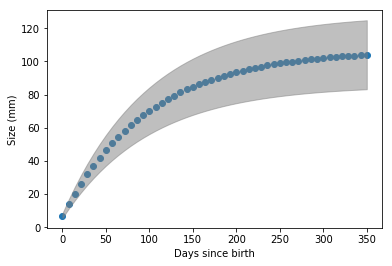

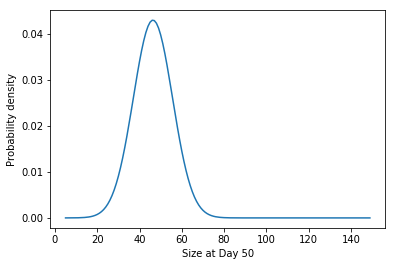

In [2]:
## Prior function


def prior_size(t,xs = np.arange(5,150)):
    s_mean = growth_func(t)
    sd = s_mean / 5
    return norm.pdf(xs,s_mean,sd)

def growth_func(t,s_max = 100):
    size = 7 + s_max - s_max/np.exp(t/100)
    return size



fig,ax = plt.subplots()
ts = np.linspace(0,350)

ax.scatter(ts,growth_func(ts))
ax.fill_between(ts,growth_func(ts)-growth_func(ts)/5,growth_func(ts)+growth_func(ts)/5,color='gray',alpha=.5)
ax.set_xlabel('Days since birth')
ax.set_ylabel('Size (mm)')
fig.show()

fig,ax = plt.subplots()

t = 50
ax.plot(np.arange(5,150),prior_size(t))
ax.set_xlabel('Size at Day 50')
ax.set_ylabel('Probability density')
fig.show()

-inf
0.1
-1
small probability: 0.5
even probability: 0.5
even probability: 0.5


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


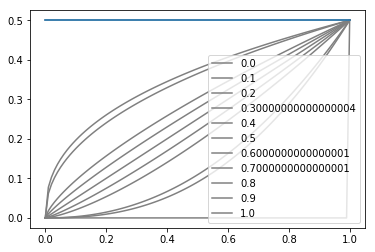

In [233]:

from scipy.special import logit

## Defines how wager relates to probability of winning for wager, w, with luck, .5
## Wager here is defined as a proportion of the greater fish's investment
def wager_curve(w,l=.25):
    a = logit(1-l)
    prob_win = w ** (float(np.abs(a))**np.sign(a)) / 2
    return prob_win
    
fig,ax = plt.subplots()
x_vals = np.linspace(0,1,100)

b = 1
a = logit(1-b)
print(a)
print(float(np.abs(10))**-1)

#ax.plot(x_vals,x_vals**2)
#ax.plot(x_vals,x_vals ** (1/2))
for l in np.linspace(0,1,11):
    ax.plot(x_vals,wager_curve(x_vals,l=l),label=str(l),color='gray')
ax.plot(x_vals,x_vals**(float(np.abs(a))**np.sign(a))/2)
print(np.sign(-1))
print('small probability:',.01 ** (float(np.abs(a))**np.sign(a))/2)
print('even probability:', 1.0 ** (float(np.abs(a))**np.sign(a))/2)
print('even probability:',wager_curve(1.0))
#ax.set_ylim([-0.1,1.1])
ax.legend()
fig.show()


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


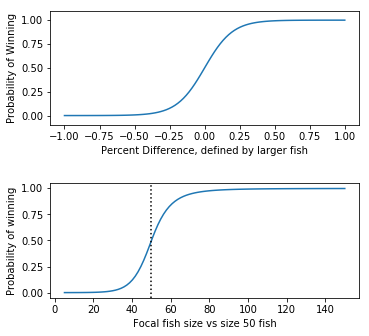

In [189]:
## Likelihood function

def win_by_ratio(r, k=0.1,m=0):
    # sigmoid function
    # use k to adjust the slope
    p = 1 / (1 + np.exp(-(r-m) / k)) 
    return p

def likelihood_function_size(x,x_opp=50):
    if x >=x_opp:
        r_diff = (x - x_opp)/x # Will be positive
    elif x_opp > x:
        r_diff = (x - x_opp)/x_opp # Will be negative
    p_win = win_by_ratio(r_diff)
    return p_win
    
def define_likelihood(x_opp=50,xs=np.arange(5,150),win=True):
    likelihood = np.zeros(len(xs))
    if win:
        for s in range(len(xs)):
            likelihood[s] = likelihood_function_size(xs[s],x_opp)
    elif not win:
        for s in range(len(xs)):
            likelihood[s] = 1-likelihood_function_size(xs[s],x_opp)
    return likelihood


fig,(ax,ax1) =plt.subplots(2)

xs = np.linspace(-1,1,100)
ax.plot(xs,win_by_ratio(xs))
ax.set_xlabel('Percent Difference, defined by larger fish')
ax.set_ylabel('Probability of Winning')
ax.set_ylim(-0.1,1.1)


xs1 = np.linspace(5,150,100)
ys1 = []
for x in xs1:
    ys1.append(likelihood_function_size(x))
ax1.plot(xs1,ys1)
ax1.axvline(50,color='black',linestyle=':')
ax1.set_xlabel('Focal fish size vs size 50 fish')
ax1. set_ylabel('Probability of winning')
fig.tight_layout()
fig.set_size_inches([5,5])
fig.show()



/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


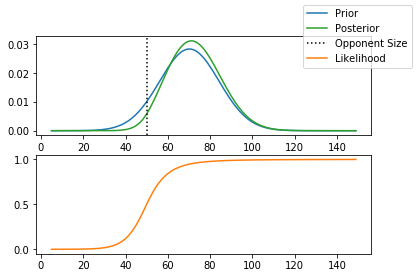

In [4]:
## Update a prior by a likelihood

## xs need to be the same for prior, likelihood, and post
def update(prior,likelihood,xs = np.arange(5,150)):
    post = prior * likelihood
    post = post / auc(xs,post)
    return post

xs = np.arange(5,150)
t = 100
x_opp = 50
win = True
prior = prior_size(t,xs)

likelihood = define_likelihood(x_opp,win=win)
    
posterior = update(prior,likelihood)

fig,(ax1,ax2) = plt.subplots(2)
ax1.plot(xs,prior,label='Prior')
ax2.plot(xs,likelihood,label='Likelihood',color='tab:orange')
ax1.plot(xs,posterior,label='Posterior',color='tab:green')
ax1.axvline(50,color='black',linestyle=':',label='Opponent Size')
fig.legend()
fig.show()

Estimated size: 46.2625250501002
(46.34709871510001, 9.269018176936278)
Fight? True
pre-sum 1.0000000000000002
post-sum 1.0
My name is: Phil
Actual size: 50.22241800702221
Size estimate: 21.56312625250501
Win record: [[20, False]]
Fight? True
Win? True
Win fixed? True
1.0
119.85368682769328 10.947770861124802
(31.04659190163085, 10.947770861124802)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


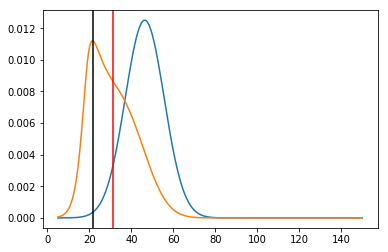

In [119]:
## Define a fish object

naive_escalation = {
      0:.10,
      1:.20,
      2:.30,
      3:.50,
      4:.70
}

## Fish object with internal rules and estimates
class Fish:
    def __init__(self,idx=0,age=50,size=None,
                 prior=None,likelihood=None,hock_estimate=.5,escalation=naive_escalation,xs=np.linspace(5,150,500)):
        self.idx = idx
        self.name = idx
        self.age = age
        self.xs = xs
        if size is not None:
            if size == 0:   
                self.size = growth_func(self.age)
            else:
                self.size = size
        else:
            mean = growth_func(self.age)
            sd = mean/5
            self.size = np.random.normal(mean,sd)
        if prior is not None:
            self.prior = pior
        else:
            self.prior = self._prior_size(self.age,xs=self.xs)
        ## Define the rules one when to escalate, based on confidence
        self.escalation_thresholds = escalation
        self.cdf_prior = self._get_cdf_prior(self.prior)
        self.estimate = self.xs[np.argmax(self.prior)]
        prior_mean,prior_std = self.get_stats()
        self.estimate_ = prior_mean
        if hock_estimate == 'estimate':
            self.hock_estimate = self.estimate
        else:
            self.hock_estimate = hock_estimate
        self.hock_record = [self.hock_estimate]
        self.win_record = []
        self.est_record = [self.estimate]
        self.est_record_ = [self.estimate_]
        self.sdest_record = [prior_std]
        
    def _get_cdf_prior(self,prior):
        normed_prior = self.prior / np.sum(self.prior)
        cdf_prior = np.cumsum(normed_prior)
        return cdf_prior

    def _update(self,prior,likelihood,xs = None):
        if xs is None:
            xs = self.xs
        post = prior * likelihood
        #post = post / auc(xs,post)
        post = post / np.sum(post)
        return post
    
    def _prior_size(self,t,xs = np.arange(5,150)):
        s_mean = self._growth_func(t)
        sd = s_mean / 5
        prior = norm.pdf(xs,s_mean,sd)
        return prior / np.sum(prior)

    def _growth_func(self,t,s_max = 100):
        size = 7 + s_max - s_max/np.exp(t/100)
        return size
    
    def update_prior(self,win,x_opp,xs=None):
        if xs is None:
            xs = self.xs
        likelihood = define_likelihood(x_opp,xs,win)
        self.win_record.append([x_opp,win])
        self.prior = self._update(self.prior,likelihood,xs)
        self.cdf_prior = self._get_cdf_prior(self.prior)
        if True: ## Need to decide which of these to use...
            estimate = self.xs[np.argmax(self.prior)] ## This is easy, but should it be the mean?
        else:
            estimate = np.sum(self.prior * self.xs / np.sum(self.prior))
        self.estimate_ = np.sum(self.prior * self.xs / np.sum(self.prior))
        
        prior_mean,prior_std = self.get_stats()
        self.est_record_.append(prior_mean)
        self.sdest_record.append(prior_std)
        
        self.estimate = estimate
        self.est_record.append(estimate)
        
        return self.prior,self.estimate
    
    def update_hock(self,win,h_opp,scale=.1):
        rel_hock = self.hock_estimate / (self.hock_estimate + h_opp)
        estimate = self.hock_estimate + scale * (win-rel_hock)
        if estimate < .001:
            estimate = .001
        self.hock_estimate = estimate
        self.hock_record.append(estimate)
        
    def plot_prior(self,ax=None):
        if ax is None:
            fig,ax = plt.subplots()
        ax.plot(self.xs,self.prior)
        if ax is None:
            fig.show()
    def summary(self): # print off a summary of the fish
        print('My number is:',self.idx)
        print('Actual size:',self.size)
        print('Size estimate:',self.estimate)
        print('Win record:',self.win_record)
        return self.name,self.size,self.estimate,self.win_record
    
    ## This needs to be divied up by strategy somehow...
    def choose_effort(self,f_opp,strategy='sa'):
        if strategy == 'sa':
            return self.estimate / 100 ## This is defined as the max fish size, which could change...
        elif strategy == 'oa':
            return 1 - f_opp.size / 100
        elif strategy == 'ma':
            ## I think we could do np.sum(self.cdf_prior * f_opp.cdf_prior)
            return np.sum(self.cdf_prior[self.xs > f_opp.size])
        elif strategy == 'ma_c': ## This is the continuous version where there is opponent uncertainty
            total_prob = 0
            opp_estimate = self.estimate_opponent(f_opp.size)
            for i in range(len(f_opp.xs)):
                s = f_opp.xs[i]
                total_prop += np.sum(self.cdf_prior[self.xs > s]) * opp_estimate[i]
            return total_prob
        else:
            return 1
    
    ## Function to estimate opponent size, should return a prior distribution of opponent size like own prior_cdf
    def estimate_opponent(self,f_opp):
        return f_opp.cdf_prior
    
    def escalate_(self,x_opp,level=0): # Decide whether to fight (or escalate a fight) against a bigger fish
        #print('Choosing whether to escalate...Estimate,opponent:',self.estimate,x_opp)

        #NOTE: Switch this to a cdf estimate (i.e. odds of winning)
        if self.estimate > x_opp * (level * .2 + 1): ## This is a wierd structure
            return True
        else:
            return False
    
    ## This is just a little wrapper for probably_bigger
    def escalate(self,x_opp,level=0):
        conf_needed = self.escalation_thresholds[level]
        if self.probably_bigger(x_opp,conf_needed):
            return True
        else:
            return False
    # Check whether you believe you are bigger with some required confidence
    def probably_bigger(self,x_opp,conf=.5):
        cutoff = self.xs[np.argmax(self.cdf_prior > (1-conf))] ## Calculate cutoff for a given confidence
        if x_opp < cutoff:
            return True
        else:
            return False
    

    def fight(self,x_opp): # Decide if you win against another fish
        prob_win = likelihood_function_size(self.size,x_opp)
        roll = np.random.random()
        if roll < prob_win: # This should be right, >= would bias it, < is fair I think
            return True
        else:
            return False
    def fight_fixed(self,x_opp): # Same as above, but the bigger fish always wins
        if self.size > x_opp:
            return True
        else:
            return False
    def get_stats(self):
        prior_mean = np.sum(self.prior * self.xs / np.sum(self.prior))
        prior_std = np.sum((self.xs - prior_mean)**2 * self.prior/(np.sum(self.prior)))
        prior_std = np.sqrt(prior_std)
        self.prior_mean = prior_mean
        self.prior_std = prior_std
        
        return prior_mean,prior_std
        
        
f1 = Fish('Phil',age=50)
print('Estimated size:',f1.estimate)
print(f1.get_stats())
print('Fight?',f1.escalate(38))
fig,ax = plt.subplots()
f1.plot_prior(ax)
print('pre-sum',np.sum(f1.prior))
f1.update_prior(win=False,x_opp=20)
print('post-sum',np.sum(f1.prior))
f1.plot_prior(ax)
#ax.plot(f1.xs,f1.prior * f1.xs,color='black')


_ = f1.summary()

print('Fight?',f1.escalate(40))
print('Win?',f1.fight(40))
print('Win fixed?',f1.fight_fixed(40))

print(np.sum(f1.prior))

prior_mean = np.sum(f1.prior * f1.xs / np.sum(f1.prior))
prior_std = np.sum((f1.xs - prior_mean)**2 * f1.prior/(np.sum(f1.prior)))
ax.axvline(prior_mean,color='red')
ax.axvline(f1.estimate,color='black')

fig.show()
print(prior_std,np.sqrt(prior_std))
print(f1.get_stats())

In [312]:
## Define simulation class:

class SimParams():
    def __init__(self,n_iterations=1000,n_fish=4,n_rounds=200,fight_selection='random',
                effort_method=[1,1],outcome_params=[.3,.3,.3],update_method='bayes',effect_strength=[1,1]):
        self.n_iterations = n_iterations
        self.n_fish = n_fish
        self.n_rounds = n_rounds
        self.fight_selection = fight_selection ## this defines how much fish can pick their opponents
        self.effort_method = effort_method     ## This is self-assessment vs opponent assessment, [1,1] is MA
        self.outcome_params = outcome_params   ## This determines how fights are settled, skill,effort,luck
        self.update_method = update_method     ## This determines how individuals update their self assessment
        self.effect_strength = effect_strength ## This determines the relative strenght of the winner & loser effects
        
    def summary(self):
        print('Number iterations:',self.n_iterations)
        print('Number of Fish:',self.n_fish)
        print('Number of rounds:',self.n_rounds)
        print('Fight Selection:',self.fight_selection)
        print('Fight Outcome:',self.outcome_params)
        print('Effort Method:',self.effort_method)
        print('Update Method:',self.update_method)

"""    def __init__(self,fishes,fight_list = None,n_fights = None,
                 f_method='balanced',f_outcome='math',f_params=[.3,.3,.3],u_method='bayes'):
"""
        
class Simulation():
    def __init__(self,params=SimParams()):
        self.params = params
        
    def run_simulation(self):
        all_stats = []
        for i in range(self.n_iterations):
            tank = self._build_tank(i)
            tank.run_all()
            t_stats = _get_tank_stats(tank)
            all_stats.append(t_stats)
    
    def _build_tank(self,i): ## I Might want the iteration info available
        p = self.params
        fishes = [Fish() for f in p.n_fish]
        n_fights = p.n_rounds
        
        return Tank(fishes,n_fights=p.n_rounds,f_method=p.fight_selection,f_params=p.outcome_params)
    
    def _get_tank_stats(self,tank):
        return self._calc_linearity(tank),self._calc_stability(tank),self._calc_accuracy(tank)
    
    def _calc_linearity(self,tank):
        n_fish = len(tank.fishes)
        h_matrix = np.zeros([n_fish,n_fish])
        win_record_dif = tank.win_record - np.transpose(tank.win_record)
        h_matrix[win_record_dif > 0] = 1
        tank.h_matrix = h_matrix
        
        ## DO THE MATHY THING HERE
        
        return linearity
        
    def _calc_stability(self,tank):
        ## This means working through tank matrix by time, and I guess it's the standard deviation or something?
        if tank.fight_selection == 'balanced':
            stability = np.mean(np.std(tank.history,axis=0))
        else:
            ## First calculate a sliding window bigger than 2*n^2. We're going to have some missing values
            min_slide = 2*tank.n_fish*(tank.n_fish-1)
            ## will need to test this...
            binned_history = np.convolve(mydata,np.ones([min_slide,tank.n_fish,tank.n_fish],dtype=int),'valid')
            stability = np.mean(np.std(binned_history,axis=0))
        return stability
    
    def _calc_accuracy(self,tank):
        ## This is the correlation between size rank and hierarchy rank
        ## It could also be the coefficient, to be even more precise...
        return 0
    
    def get_timed_means(self):
        ## Maybe this is a bad idea actually...It's really just binned history.
        return linearity_history,stability_history,accuracy_history
    
    def get_mean_stats(self): ## this is calculating these across all tanks
        
        return mean_linearity,mean_stability,mean_accuracy
    
    def get_final_stats(self): ## This is calculating across all thanks, but only using the final info
        
        return final_linearity,final_stability,final_accuracy

IndentationError: expected an indented block (<ipython-input-312-5bcba7c4f132>, line 76)

In [249]:
## Define a long-term tank class:

## Fight is a dictionary or maybe class:
#Fish 1 vs Fish 2
#Winner: Fish 2
#Extent: None


## Super simple object to keep track of matchups (and decide outcome if necessary)
class Fight():
    def __init__(self,fish1,fish2,outcome="math",outcome_params=[.3,.3,.3],level=None,idx=0):
        self.fish1 = fish1
        self.fish2 = fish2
        self.fishes = [fish1,fish2]
        self.mechanism = outcome
        self.level = level
        self.outcome = '?'
        self.params = outcome_params
        self.idx = idx
        
    def run_outcome(self):
        if self.mechanism == 'chance':
            self.outcome = self.chance_outcome()
        elif self.mechanism == 'escalate':
            self.outcome,self.level = self.escalating_outcome()
        elif self.mechanism == 'escalate_level':
            self.outcome,self.level = self.escalating_by_level()
        elif self.mechanism == 'wager':
            self.outcome,self.level = self.wager()
        elif self.mechanism == 'wager_estimate':
            self.outcome,self.level = self.wager_estimate()
        elif self.mechanism == 'wager_chance':
            self.outcome,self.level = self.wager_chance()
        elif self.mechanism == 'hock':
            self.outcome,self.level = self.hock_huber()
        elif self.mechanism == 'math':
            self.outcome,self.level = self.mathy(self.params)
            
        else:
            self.outcome = self.mechanism
      
        self.winner = self.fishes[self.outcome]
        self.loser = self.fishes[1-self.outcome]
        
    def chance_outcome(self): ## This just pulls from the fish.fight, basically a dice roll vs the likelihood
        prob_win = likelihood_function_size(self.fish1.size,self.fish2.size)
        self.prob_win = prob_win
        if np.random.random() < prob_win:
            return 0
        else:
            return 1
    
    def escalating_outcome(self):
        cont = True
        level = 0
        focal_fish = np.random.choice([0,1])
        while cont and level < 5:
            focal_fish = 1-focal_fish  ## define the focal fish
            other_fish = 1-focal_fish  ## The other fish is defined as the other fish
            cont = self.fishes[focal_fish].escalate_(self.fishes[other_fish].size)
            if cont == True:
                level += 1
            else:
                return 1-focal_fish,level
        ## IF you escalate to 3, return the winner based on likelihood curve
        winner = self.chance_outcome()
        return winner,level
            
    def escalating_by_level(self):
        cont = True
        level = 0
        focal_fish = np.random.choice([0,1])
        while cont and level < 5:
            focal_fish = 1-focal_fish  ## define the focal fish
            other_fish = 1-focal_fish  ## The other fish is defined as the other fish
            cont = self.fishes[focal_fish].escalate(self.fishes[other_fish].size,level)
            if cont == True:
                level += 1
            else:
                return 1-focal_fish,level
        ## IF you escalate to 3, return the winner based on likelihood curve
        winner = self.chance_outcome()
        return winner,level

    def _wager_curve(self,w,l=.25):
        a = logit(1-l)
        prob_win = w ** (float(np.abs(a))**np.sign(a)) / 2
        return prob_win

    ## This is useful because it paramaterizes the relative impact of size, effort, and luck
    def mathy(self,param=[.5,.5,.5]):
        s,e,l = param
        f1_size = self.fish1.size
        f2_size = self.fish2.size
        max_size = max([f1_size,f2_size])
        f1_rel_size = f1_size / max_size
        f2_rel_size = f2_size / max_size
        f1_effort = self.fish1.choose_effort(self.fish2)
        f2_effort = self.fish2.choose_effort(self.fish1)
        f1_wager = (f1_rel_size ** s) * (f1_effort ** e)
        f2_wager = (f2_rel_size ** s) * (f2_effort ** e)
        min_wager = min([f1_wager,f2_wager]) / (f1_wager + f2_wager)
        f_min = np.argmin([f1_wager,f2_wager])
        p_win = self._wager_curve(min_wager,l)
        if random.random() < p_win: ## probability that the "lower invested" fish wins
            winner = f_min
            level = min_wager
        else:
            winner = 1-f_min
            level = min_wager
        return winner,level
    
    ## Choose based off of estimate
    def wager(self):
        ## Get each fish's estimated probability of being bigger 
        f1_wager = 1 - self.fish1.cdf_prior[np.argmax(self.fish1.xs > self.fish2.size)]
        f2_wager = 1 - self.fish2.cdf_prior[np.argmax(self.fish2.xs > self.fish1.size)]
        if f1_wager > f2_wager:
            winner = 0
            level = f2_wager
        elif f2_wager > f1_wager:
            winner = 1
            level = f1_wager
        elif f2_wager == f1_wager:
            winner = self.chance_outcome()
            level = f1_wager
        return winner, level
    
    def wager_estimate(self):
        f1_wager = self.fish1.estimate
        f2_wager = self.fish2.estimate
        if f1_wager > f2_wager:
            winner = 0
            level = f2_wager
        elif f2_wager > f1_wager:
            winner = 1
            level = f1_wager
        elif f2_wager == f1_wager:
            winner = self.chance_outcome()
            level = f1_wager
        return winner, level
    
    def wager_chance(self):
        f1_wager = self.fish1.estimate
        f2_wager = self.fish2.estimate
        #prob_f1 = f1_wager / (f1_wager + f2_wager)
        prob_f1 = likelihood_function_size(f1_wager,f2_wager)
        if random.random() < prob_f1:
            winner = 0
        else:
            winner = 1
        level = min([f1_wager,f2_wager])
        return winner,level
    
    def hock_huber(self,scale=.1):
        f1_est = self.fish1.hock_estimate
        f2_est = self.fish1.hock_estimate
        prob_f1 = f1_est / (f1_est + f2_est)
        if random.random() < prob_f1:
            winner = 0
        else:
            winner = 1
        level = min([f1_est,f2_est]) * scale
        return winner,level
    
    def summary(self):
        prob_outcome = self.prob_win
        if self.outcome:
            prob_outcome = 1 - prob_outcome
        
        return ' '.join([str(self.fish1.name),'vs',str(self.fish2.name),str(self.outcome),': So,',str(self.winner.name),'won, with probability',str(prob_outcome)])


class Tank():
    def __init__(self,fishes,fight_list = None,n_fights = None,
                 f_method='balanced',f_outcome='math',f_params=[.3,.3,.3],u_method='bayes'):
        self.fishes = fishes
        self.f_method = f_method
        self.f_outcome = f_outcome
        self.u_method = u_method
        self.win_record = np.zeros([len(fishes),len(fishes)])
        
        if fight_list is not None:
            self.fight_list = fight_list
        else:
            if n_fights is None:
                ## if n is not defined, just run each one once
                self.fight_list = self.get_matchups(f_method,f_outcome)
                self.n_fights = len(self.fight_list)
            else:
                self.fight_list = self.get_matchups(f_method,f_outcome,n_fights)
        self.history = np.zeros([n_fights,len(fishes),len(fishes)])
        
    
    ## Randomly match up fishes
    
    def get_matchups(self,f_method='balanced',f_outcome='chance',n_fights=10):
        fight_list = []
        
        if f_method == 'balanced':
            short_list = []
            for i in range(n_fights):
                for f1,f2 in itertools.combinations(self.fishes, 2):
                    fight_list.append(Fight(f1,f2,outcome=f_outcome,idx=i)) ## So balanced is organized as rounds
        if f_method == 'random':
            combs = list(itertools.combinations(self.fishes,2))
            for n in range(n_fights):
                f1,f2 = random.choice(combs)
                fight_list.append(Fight(f1,f2,outcome=f_outcome,idx=i))
        return fight_list
    
    def process_fight(self,fight): ## This works without returning because of how objects work in python
        fight.run_outcome()
        #print('before,after')
        #print(fight.winner.estimate)
        fight.winner.update_prior(True,fight.loser.size)
        #print(fight.winner.estimate)
        #print()
        fight.loser.update_prior(False,fight.winner.size)
        #return fight.winner,fight.loser
        self.win_record[fight.winner.idx,fight.loser.idx] += 1
        self.history[fight.idx,fight.winner.idx,fight.loser.idx] = 1 ## Note, this works a bit different for 'random' and 'balanced'
        
    def process_hock(self,fight):
        fight.run_outcome()
        fight.winner.update_hock(True,fight.loser.hock_estimate,fight.level)
        fight.loser.update_hock(False,fight.winner.hock_estimate,fight.level)
    
    def print_status(self):
        for f in self.fishes:
            print(f.name,':',f.size,f.estimate)
    def run_all(self,print_me=False):
        if print_me:
            print("Starting fights!")
            print("Initial status_____")
            self.print_status()
        if self.u_method == 'hock':
            process = self.process_hock
        else:
            process = self.process_fight
        for c in self.fight_list:
            process(c)
            if print_me:
                print('UPDATE:_____')
                print(c.summary())
                self.print_status()
    def __getitem__(self,idx):
        return self.fishes[idx]

f0 = Fish(0,age=50)
f1 = Fish(1,age=50)

f2 = Fish(2,age=50)

fish_list = [f0,f1,f2]
          

fight0 = Fight(f0,f1)
fight1 = Fight(f1,f2)
fight2 = Fight(f2,f0)
fight_list = [fight0,fight1,fight2]

t0 = Tank(fish_list,f_method = 'random',f_outcome='escalate',n_fights=1000)
t0.print_status()
print(t0[0].name)

t0.run_all()
print('Running 100 times...')
t0.print_status()

0 : 43.077744352093696 46.2625250501002
1 : 56.196508139944946 46.2625250501002
2 : 29.9702593252293 46.2625250501002
0
Running 100 times...
0 : 43.077744352093696 41.032064128256515
1 : 56.196508139944946 76.19238476953907
2 : 29.9702593252293 18.366733466933866


In [311]:
f0 = Fish(0,age=50,size=50)
f1 = Fish(1,age=55,size=49)

fight_test = Fight(f0,f1,outcome='math',outcome_params=[0,1,0])
print('pre outcome',fight_test.outcome)
print(f0.estimate,f1.estimate)
print(f0.size,f1.size)
print('wager,test:',fight_test.wager())
print('mathy test:',fight_test.mathy())
fight_test.run_outcome()
fight_test.winner.update_prior(True,fight_test.loser.size)
fight_test.loser.update_prior(False,fight_test.winner.size)
print('outcome',fight_test.outcome,fight_test.level)
print('posterior estimates:',f0.estimate,f1.estimate)

pre outcome ?
46.2625250501002 49.168336673346694
50 49
wager,test: (1, 0.3744606050348669)
mathy test: (1, 0.49491081247320423)
outcome 1 0.4847753044939101
posterior estimates: 42.48496993987976 54.39879759519038


In [8]:
f0 = Fish(0)
f1 = Fish(1)

print(f1.estimate,f0.size)
print(f1.probably_bigger(f0.size,.5))
print(f1.probably_bigger(f1.size,.5))

t1 = Tank([f0,f1],f_method = 'balanced',f_outcome='escalate_level',n_fights=3)
print(t1.fight_list[0].outcome,t1.fight_list[0].level)
t1.print_status()
t1.run_all()
t1.print_status()
print(t1.fight_list[0].outcome,t1.fight_list[0].level)

print(f1.estimate,f0.size)
print(f1.probably_bigger(f0.size,.1))

46.2625250501002 40.51237129576411
True
True
? None
0 : 40.51237129576411 46.2625250501002
1 : 10.132536145645048 46.2625250501002
0 : 40.51237129576411 46.2625250501002
1 : 10.132536145645048 34.63927855711423
0 5
34.63927855711423 40.51237129576411
False


In [86]:
test_method = np.mean
print(test_method([1,2,3]))

2.0


In [9]:
normed_prior = f1.prior / np.sum(f1.prior)
cdf_prior = np.cumsum(normed_prior)
print(f1.xs[cdf_prior > .5][0])


print(f1.xs[np.argmax(cdf_prior > .5)])

33.76753507014028
33.76753507014028


?
0 : 47.9777928103587 46.2625250501002
1 : 47.15575062848105 46.2625250501002
2 : 50.67804961917083 46.2625250501002
3 : 52.49345433365116 46.2625250501002
4 : 48.4875572776441 46.2625250501002
Running 1000 times...
0 : 47.9777928103587 79.96993987975952
1 : 47.15575062848105 49.45891783567134
2 : 50.67804961917083 46.55310621242485
3 : 52.49345433365116 28.246492985971944
4 : 48.4875572776441 52.07414829659319


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


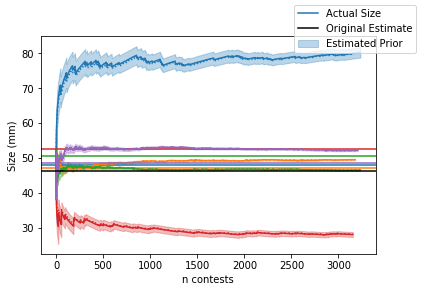

In [115]:
if True:
    f0 = Fish(0,age=50)
    f1 = Fish(1,age=50)

    f2 = Fish(2,age=50)
    f3 = Fish(3,age=50)
    f4 = Fish(4,age=50)

    fish_list = [Fish(f,age=50) for f in range(5)]
    #fish_list = [Fish(f,age=50) for f in range(5)]

    t0 = Tank(fish_list,f_method = 'random',f_outcome='wager_chance',n_fights=8000)
else:
    t0 = Tank(fish_list,f_method = 'random',f_outcome='wager',n_fights=8000)

print(t0.fight_list[0].outcome)

t0.print_status()
t0.run_all()
print('Running 1000 times...')
t0.print_status()

fig,ax = plt.subplots()

sizes = []
for i in range(len(t0.fishes)):
    f = t0.fishes[i]
    sizes.append(f.size)
    ax.plot(f.est_record,color=cm.tab10(i),linestyle=':')
    ax.plot(f.est_record_,color=cm.tab10(i))
    if i == 0:
        ax.axhline(f.size,color =cm.tab10(i),label='Actual Size')
        ax.fill_between(np.arange(len(f.est_record)),np.array(f.est_record_) + np.array(f.sdest_record),
                    np.array(f.est_record_) - np.array(f.sdest_record),
                    color=cm.tab10(i),alpha=.3,label='Estimated Prior')
    else:
        ax.axhline(f.size,color =cm.tab10(i))
        ax.fill_between(np.arange(len(f.est_record)),np.array(f.est_record_) + np.array(f.sdest_record),
                    np.array(f.est_record_) - np.array(f.sdest_record),
                    color=cm.tab10(i),alpha=.3)
    
ax.axhline(growth_func(50),color='black',label='Original Estimate')
ax.set_xlabel('n contests')
ax.set_ylabel('Size (mm)')
#ax.set_ylim([min(sizes)*.8,max(sizes)*1.3])
#ax.set_ylim([47,53])
fig.legend()
fig.show()

?
0 : 31.20250248268392 46.2625250501002
1 : 36.882314365082614 46.2625250501002
2 : 40.18805628049627 46.2625250501002
3 : 48.70614087313881 46.2625250501002
4 : 39.492478832851475 46.2625250501002
Running 1000 times...
0 : 31.20250248268392 46.2625250501002
1 : 36.882314365082614 46.2625250501002
2 : 40.18805628049627 46.2625250501002
3 : 48.70614087313881 46.2625250501002
4 : 39.492478832851475 46.2625250501002


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


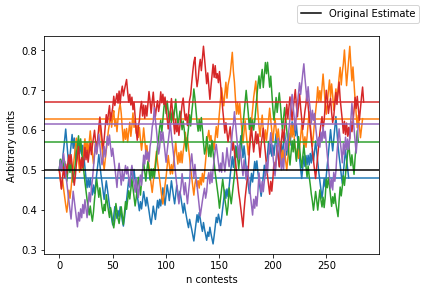

In [114]:
## Run with Hock-Huber approach

if True:
    f0 = Fish(0,age=50)
    f1 = Fish(1,age=50)

    f2 = Fish(2,age=50)
    f3 = Fish(3,age=50)
    f4 = Fish(4,age=50)

    fish_list = [Fish(f,age=50) for f in range(5)]
    #fish_list = [Fish(f,age=50) for f in range(5)]

    t0 = Tank(fish_list,f_method = 'random',f_outcome='hock',u_method='hock',n_fights=700)

print(t0.fight_list[0].outcome)

t0.print_status()
t0.run_all()
print('Running 1000 times...')
t0.print_status()

fig,ax = plt.subplots()

sizes = []
for i in range(len(t0.fishes)):
    f = t0.fishes[i]
    sizes.append(f.size)
    ax.plot(f.hock_record,color=cm.tab10(i))
    ax.axhline(f.hock_record[-1],color=cm.tab10(i))
    
ax.axhline(f.hock_record[0],color='black',label='Original Estimate')
ax.set_xlabel('n contests')
ax.set_ylabel('Arbitrary units')
#ax.set_ylim([min(sizes)*.8,max(sizes)*1.3])
#ax.set_ylim([47,53])
fig.legend()
fig.show()

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


(44.39683920759835, 0.33637187023537046)

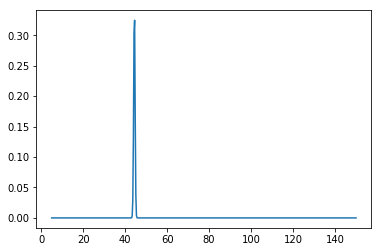

In [12]:
fig,ax = plt.subplots()

ax.plot(fish_list[0].xs,fish_list[0].prior)
fig.show()

fish_list[0].get_stats()

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


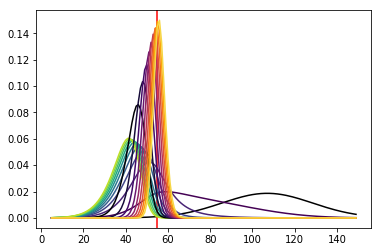

In [13]:
## How many losses does it take to become fixed in a new idea: 
## Answer: Depends a lot on the strength of your existing prior

xs = np.arange(5,150)
t = 1500
x_opp = 55
win = False
prior = prior_size(t,xs)

likelihood_w = define_likelihood(x_opp,xs,win=True)

likelihood_l = define_likelihood(x_opp,xs,win=False)

fig,ax = plt.subplots()
ax.plot(xs,prior,color='black')

ax.axvline(x_opp,color='red')
N = 10
for i in range(N):
    posterior = update(prior,likelihood_l)
    ax.plot(xs,posterior,color=cm.viridis(i/N))
    prior = posterior
    
for i in range(N):
    posterior = update(prior,likelihood_w)
    ax.plot(xs,posterior,color=cm.inferno(i/N))
    prior = posterior
fig.show()

34.231221276268755
21.56312625250501
21.56312625250501


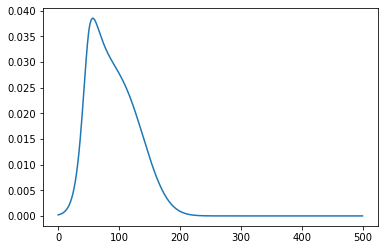

In [ ]:
fig,ax = plt.subplots()
ax.plot(f1.prior)
print(f1.size)
print(f1.estimate)
print(f1.xs[np.argmax(f1.prior)])

47.65575439996869


/tmp/ipykernel_7584/1060894873.py:127: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


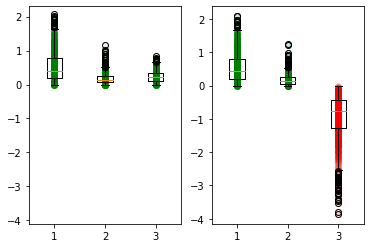

In [ ]:
## expected, same expected, size-matched surprise
f1 = Fish()

print(f1.size)
## Note that because of the nature of objects, this will update the fish as you go

SHIFT_h = True
def win_win_lose(fish,opp_scale=.88,plot_me=False):
    x_opp1 = fish.size * opp_scale
    x_opp2 = fish.size * opp_scale
    x_opp3 = fish.size
    
    if plot_me:
        fig,ax = plt.subplots()
        fish.plot_prior(ax)
    
    prior0 = fish.prior
    est0 = fish.estimate
    posterior1,est1 = fish.update_prior(True,x_opp1)
    if SHIFT_h:
        shift1 = np.sum(rel_entr(posterior1,prior0)) * np.sign(est1-est0)
    else:
        shift1 = est1 - est0
    if plot_me:
        fish.plot_prior(ax)
    
    posterior2,est2 = fish.update_prior(True,x_opp2)
    
    if SHIFT_h:
        shift2 = np.sum(rel_entr(posterior2,posterior1)) * np.sign(est2-est1)
    else:
        shift2 = est2 - est1
    
    if plot_me:
        fish.plot_prior(ax)
    
    posterior3,est3 = fish.update_prior(False,x_opp3)
    if SHIFT_h:
        shift3 = np.sum(rel_entr(posterior3,posterior2)) * np.sign(est3-est2)
    else:
        shift3 = est3 - est2
    #print(np.sum(rel_entr(posterior3,posterior2)))
    if plot_me:
        fish.plot_prior(ax)
    return shift1,shift2,shift3

def win_win_win(fish,opp_scale=.88,plot_me=False):
    x_opp1 = fish.size * opp_scale
    x_opp2 = fish.size * opp_scale
    x_opp3 = fish.size
    
    if plot_me:
        fig,ax = plt.subplots()
        fish.plot_prior(ax)
    
    prior0 = fish.prior
    est0 = fish.estimate
    posterior1,est1 = fish.update_prior(True,x_opp1)
    if SHIFT_h:
        shift1 = np.sum(rel_entr(posterior1,prior0)) * np.sign(est1-est0)
    else:
        shift1 = est1 - est0
    if plot_me:
        fish.plot_prior(ax)
    
    posterior2,est2 = fish.update_prior(True,x_opp2)
    if SHIFT_h:
        shift2 = np.sum(rel_entr(posterior2,posterior1)) * np.sign(est2-est1)
    else:
        shift2 = est2 - est1
    
    if plot_me:
        fish.plot_prior(ax)
    
    posterior3,est3 = fish.update_prior(True,x_opp3)
    
    if SHIFT_h:
        shift3 = np.sum(rel_entr(posterior3,posterior2)) * np.sign(est3-est2)
    else:
        shift3 = est3 - est2
    #print(np.sum(rel_entr(posterior3,posterior2)))
    if plot_me:
        fish.plot_prior(ax)
    return shift1,shift2,shift3

N = 1000
fishes0 = []
win00,win01,loss02 = [],[],[]


fig,(ax1,ax0) = plt.subplots(1,2)
alph = .1

opp_scale = .88
for n in range(N):
    fishes0.append(Fish(n))
    shifts = win_win_lose(fishes0[n],opp_scale)
    win00.append(shifts[0])
    win01.append(shifts[1])
    loss02.append(shifts[2])
    
ax0.boxplot([win00,win01,loss02])
ax0.scatter([1]*N,win00,color='green',alpha=alph)
ax0.scatter([2]*N,win01,color='green',alpha=alph)
ax0.scatter([3]*N,loss02,color='red',alpha=alph)
#ax0.set_ylim([-1,1])


fishes1 = []
win10,win11,win12 = [],[],[]

for n in range(N):
    fishes1.append(Fish(n))
    shifts = win_win_win(fishes1[n],opp_scale)
    win10.append(shifts[0])
    win11.append(shifts[1])
    win12.append(shifts[2])
    

ax1.boxplot([win10,win11,win12])
ax1.scatter([1]*N,win10,color='green',alpha=alph)
ax1.scatter([2]*N,win11,color='green',alpha=alph)
ax1.scatter([3]*N,win12,color='green',alpha=alph)

ax1.set_ylim([-4.1,2.3])

fig.show()




40.72774321711426


/tmp/ipykernel_7584/2706600171.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


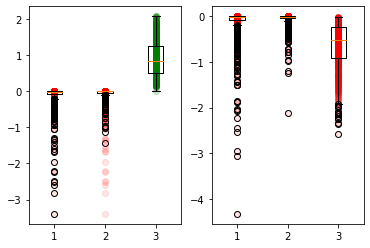

In [ ]:
## expected, same expected, size-matched surprise
f1 = Fish(1)

print(f1.size)
## Note that because of the nature of objects, this will update the fish as you go
def lose_lose_win(fish,opp_scale=1.14,plot_me=False):
    x_opp1 = fish.size * opp_scale
    x_opp2 = fish.size * opp_scale
    x_opp3 = fish.size
    
    if plot_me:
        fig,ax = plt.subplots()
        fish.plot_prior(ax)
    
    prior0 = fish.prior
    est0 = fish.estimate
    posterior1,est1 = fish.update_prior(False,x_opp1)
    
    if SHIFT_h:
        shift1 = np.sum(rel_entr(posterior1,prior0)) * np.sign(est1-est0)
    else:
        shift1 = est1 - est0
    if plot_me:
        fish.plot_prior(ax)
    
    posterior2,est2 = fish.update_prior(False,x_opp2)
    if SHIFT_h:
        shift2 = np.sum(rel_entr(posterior2,posterior1)) * np.sign(est2-est1)
    else:
        shift2 = est2 - est1
    
    if plot_me:
        fish.plot_prior(ax)
    
    posterior3,est3 = fish.update_prior(True,x_opp3)
    if SHIFT_h:
        shift3 = np.sum(rel_entr(posterior3,posterior2)) * np.sign(est3-est2)
    else:
        shift3 = est3 - est2
    
    #print(np.sum(rel_entr(posterior3,posterior2)))
    if plot_me:
        fish.plot_prior(ax)
    return shift1,shift2,shift3

def lose_lose_lose(fish,opp_scale=1.14,plot_me=False):
    x_opp1 = fish.size * opp_scale
    x_opp2 = fish.size * opp_scale
    x_opp3 = fish.size
    
    if plot_me:
        fig,ax = plt.subplots()
        fish.plot_prior(ax)
    
    prior0 = fish.prior
    est0 = fish.estimate
    posterior1,est1 = fish.update_prior(False,x_opp1)
    if SHIFT_h:
        shift1 = np.sum(rel_entr(posterior1,prior0)) * np.sign(est1-est0)
    else:
        shift1 = est1 - est0
    
    if plot_me:
        fish.plot_prior(ax)
    
    posterior2,est2 = fish.update_prior(False,x_opp2)
    if SHIFT_h:
        shift2 = np.sum(rel_entr(posterior2,posterior1)) * np.sign(est2-est1)
    else:
        shift2 = est2 - est1
    
    if plot_me:
        fish.plot_prior(ax)
    
    posterior3,est3 = fish.update_prior(False,x_opp3)
    if SHIFT_h:
        shift3 = np.sum(rel_entr(posterior3,posterior2)) * np.sign(est3-est2)
    else:
        shift3 = est3 - est2
    #print(np.sum(rel_entr(posterior3,posterior2)))
    if plot_me:
        fish.plot_prior(ax)
    return shift1,shift2,shift3

N = 1000
fishes0 = []
lose00,lose01,win02 = [],[],[]


fig,(ax0,ax1) = plt.subplots(1,2)
alph = .1

opp_scale = 1.50
for n in range(N):
    fishes0.append(Fish(n))
    shifts = lose_lose_win(fishes0[n],opp_scale)
    lose00.append(shifts[0])
    lose01.append(shifts[1])
    win02.append(shifts[2])
    
ax0.boxplot([lose00,lose01,win02])
ax0.scatter([1]*N,lose00,color='red',alpha=alph)
ax0.scatter([2]*N,lose00,color='red',alpha=alph)
ax0.scatter([3]*N,win02,color='green',alpha=alph)
#ax0.set_ylim([-1,1])


fishes1 = []
loss10,loss11,loss12 = [],[],[]

for n in range(N):
    fishes1.append(Fish(n))
    shifts = lose_lose_lose(fishes1[n],opp_scale)
    loss10.append(shifts[0])
    loss11.append(shifts[1])
    loss12.append(shifts[2])
    

ax1.boxplot([loss10,loss11,loss12])
ax1.scatter([1]*N,loss10,color='red',alpha=alph)
ax1.scatter([2]*N,loss11,color='red',alpha=alph)
ax1.scatter([3]*N,loss12,color='red',alpha=alph)
#ax1.set_ylim([-1,1])

fig.show()


In [ ]:
from math import comb
import itertools,random

comb(3,2)

import itertools,random

    
matchup = random.choice(list(itertools.combinations(fish_list,2)))
print(matchup[0].name,matchup[1].name)

0 1


51.38907543508029
51.49810024404117


(4.649298597194388, 2.034068136272545, 2.324649298597194)

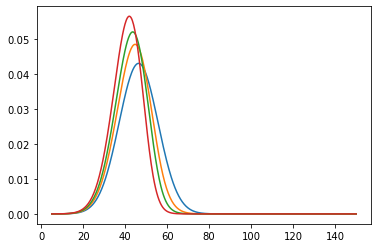

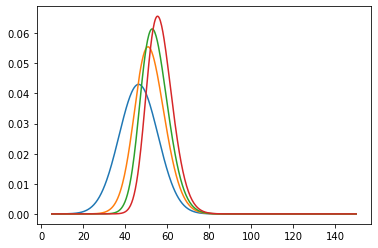

In [ ]:
loser = Fish('george')
print(loser.size)
lose_lose_lose(loser,opp_scale=1.1,plot_me=True)

winner = Fish('barry')
print(winner.size)
win_win_win(winner,opp_scale=0.9,plot_me=True)

entropy from loss: 0.37202357790785967
shift from loss: -4.93987975951903
93.33667334669339 > 88.39679358717436
93.46647167633873 93.33667334669339
entropy from win 0.7181659259427353
shift from win: 4.9398797595190445
93.33667334669339 > 98.27655310621243


/tmp/ipykernel_7584/498811729.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


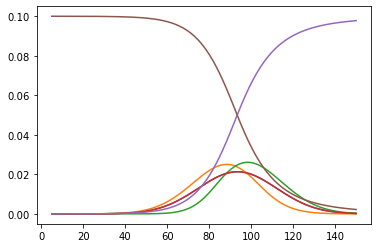

In [ ]:
age = 200
loser = Fish('mitch',age=age,size=0)
winner = Fish('barack',age=age,size=0)

prior_l = loser.prior
est_l0 = loser.estimate
post_l,est_l1 = loser.update_prior(False,loser.size*1.1364)

post_l_ = loser.prior

fig,ax = plt.subplots()
ax.plot(loser.xs,prior_l)
ax.plot(loser.xs,post_l)


print("entropy from loss:",np.sum(rel_entr(prior_l,post_l)))
#print("same?",post_l == post_l_)

print("shift from loss:",est_l1 - est_l0)
print(est_l0,'>',est_l1)
print(winner.size,winner.estimate)
likelihood_w = define_likelihood(winner.estimate,winner.xs,True)
likelihood_l = define_likelihood(winner.estimate,winner.xs,False)

prior_w = winner.prior
est_w0 = winner.estimate

post_w,est_w1 = winner.update_prior(True,winner.size*0.88)
post_w_ = winner.prior
ax.plot(winner.xs,post_w)

ax.plot(winner.xs,prior_w)
ax.plot(winner.xs,likelihood_w/10)
ax.plot(winner.xs,likelihood_l/10)
fig.show()

print("entropy from win",np.sum(rel_entr(prior_w,post_w)))
#print("same?",post_w == post_w_)
print("shift from win:",est_w1 - est_w0)
print(est_w0,'>',est_w1)

/tmp/ipykernel_7584/3797804506.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


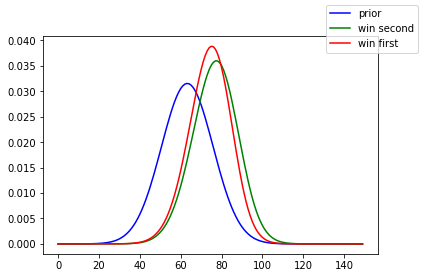

In [ ]:
## Win, lose vs lose, win:
## Winning second is better (why is that? Is it always true?)

xs = np.arange(5,150)
t = 100
x_opp = 90
win = False
prior = prior_size(t,xs)

likelihood_w = np.zeros_like(prior)
likelihood_l = np.zeros_like(prior)

for s in range(len(likelihood)):
    likelihood_w[s] = likelihood_function_size(s,x_opp)  
    likelihood_l[s] = 1-likelihood_function_size(s,x_opp)
    
wl_post = update(prior,likelihood_w)
wl_post = update(wl_post,likelihood_l)

lw_post = update(prior,likelihood_l)
lw_post = update(prior,likelihood_w)

fig,ax = plt.subplots()

ax.plot(xs,prior,color='blue',label='prior')
ax.plot(xs,lw_post,color='green',label='win second')
ax.plot(xs,wl_post,color='red',label='win first')

fig.legend()
fig.show()


In [ ]:
## How long does the winner effect persist? 

# Win or lose the first fight, then 

/tmp/ipykernel_7584/1901349285.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


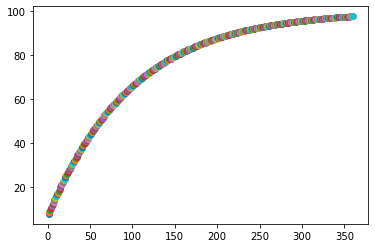

In [ ]:
## Old stuff

def size(n_days):
    max_size = 100
    size = days / 5
    return size

def growth(s0):
    max_size = 100
    s1 = s0 + (max_size - s0) / 100
    return s1

s = 7
t = 0
fig,ax = plt.subplots()
while s < 100 and t < 360:
    t += 1
    s = growth(s)
    ax.scatter(t,s)
    
fig.show()

In [ ]:
## Growth is super complicated, for now, assume that, at any given point, there is no growth 
# I think a key insight here is going to be that variable growth is really what drives these dynamics.